In [1]:
# Data manipulation
import pandas as pd
import numpy as np
# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline
MAX_EVALS = 20
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
import json
import shlex
import subprocess
import logging
from pprint import pprint
import re
import os


In [2]:
file_suffix = "S3D-IO-400-400-400-2-2-4-1" + str(MAX_EVALS)
def runthebenchmark(hyperparameters):
    os.chdir('/home/dsinghvi/project/progress/active/../')
    storeinfile(hyperparameters)
    out=subprocess.Popen(["python3","read_config_general.py","-n 2","-c400 400 400 2 2 4 1"], shell=False, stdout=subprocess.PIPE)
    logging.basicConfig(level=logging.DEBUG)
    output=out.stdout.read().decode('utf-8')
    print("output"+output)
    if len(output.split(" ")) > 5:
        values = output.split(" ")
        value = float(float(values[6])*1024)/float(values[5]) + float(float(values[3])*1024)/float(values[2])
        value = float(value)
        print(value)
        return float(value**3),output
    return 0,0;

In [3]:
def storeinfile(hyperparameters):
    data={"mpi": {"romio_ds_read": "enable", "romio_ds_write": "disable"}, "lfs": {"setstripe": {"size": "16777216", "count": 4}}}
    data["lfs"]["setstripe"]["size"] = int(hyperparameters["setstripe-size"])
    data["lfs"]["setstripe"]["count"] = int(hyperparameters["setstripe-count"])

    data["mpi"]["romio_ds_read"] = hyperparameters["romio_ds_read"]
    data["mpi"]["romio_ds_write"] = hyperparameters["romio_ds_write"]
    data["mpi"]["romio_cb_read"] = hyperparameters["romio_cb_read"]
    data["mpi"]["romio_cb_write"] = hyperparameters["romio_cb_write"]
    data["mpi"]["cb_buffer_size"] = str(int(hyperparameters["cb_buffer_size"]))
    with open("confex.json","w") as fp:
        json.dump(data,fp)
    print(data)


In [4]:
def objective(hyperparameters):
    global ITERATION
    ITERATION += 1
    start = timer()
    result=0
    while(result == 0):
        print("rerun")
        result,output = runthebenchmark(hyperparameters)
        print(result)
    run_time = timer() - start
    print({'loss': result, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK})
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([float(result), hyperparameters, ITERATION, run_time, output])
    return {'loss': float(result), 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK}


In [5]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

space = {
    'romio_ds_read' : hp.choice('romio_ds_read',['enable','disable']),
    'romio_ds_write' : hp.choice('romio_ds_write',['enable','disable']),
    'romio_cb_read' : hp.choice('romio_cb_read',['enable','disable']),
    'romio_cb_write' : hp.choice('romio_cb_write',['enable','disable']),
    'cb_buffer_size' : 1048576*hp.quniform('cb_buffer_size',1,512,1),
    'setstripe-size' : 65536*(hp.qloguniform('setstripe-size',0,7,1)),
    'setstripe-count' : hp.qloguniform('setstripe-count',0,5,1)
    
}

In [6]:
x = sample(space)
params = x
print(x)

cb_buffer_size_dist = []
for _ in range(1000):
    cb_buffer_size_dist.append(sample(space)['cb_buffer_size'])
    
setstripe_size_dist = []
for _ in range(1000):
    setstripe_size_dist.append(sample(space)['setstripe-size'])
    
setstripe_count_dist = []
for _ in range(1000):
    setstripe_count_dist.append(sample(space)['setstripe-count']) 
    
romio_ds_read_dist = []
for _ in range(20):
    romio_ds_read_dist.append(sample(space)['romio_ds_read'])
    
romio_ds_write_dist = []
for _ in range(20):
    romio_ds_write_dist.append(sample(space)['romio_ds_write'])
    
romio_cb_read_dist = []
for _ in range(20):
    romio_cb_read_dist.append(sample(space)['romio_cb_read']) 
    
romio_cb_write_dist = []
for _ in range(20):
    romio_cb_write_dist.append(sample(space)['romio_cb_write']) 
    

{'cb_buffer_size': 216006656.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 17.0, 'setstripe-size': 65536.0}


In [7]:
# File to save first results
print(os.getcwd())
out_file = '/home/dsinghvi/project/progress/active/result/gbm_trials-'+file_suffix+'.csv'

of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'train_time', 'output'])
of_connection.close()

/home/dsinghvi/project/progress/active


In [8]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest


from hyperopt import Trials

# Record results
bayes_trials = Trials()

from hyperopt import fmin


ITERATION = 20

best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = bayes_trials, max_evals = MAX_EVALS)

rerun                                               
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '189792256'}, 'lfs': {'setstripe': {'size': 30801920, 'count': 62}}}
outputS3D-IO 400-400-400-2-2-4-1 677.58 7.63 11.53 602.71 22.89 38.89 0.09 0.29 30801920 62 enable enable disable enable 189792256 

50.4208659306795                                    
128183.13824703319                                  
{'loss': 128183.13824703319, 'hyperparameters': {'cb_buffer_size': 189792256.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 62.0, 'setstripe-size': 30801920.0}, 'iteration': 21, 'iteration_time': 57.598907770588994, 'status': 'ok'}
  5%|▌         | 1/20 [00:57<18:14, 57.61s/it, best loss: 128183.13824703319]

INFO:hyperopt.tpe:tpe_transform took 0.012046 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 128183.138247


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '340787200'}, 'lfs': {'setstripe': {'size': 393216, 'count': 25}}}
outputS3D-IO 400-400-400-2-2-4-1 728.46 7.63 10.73 694.37 22.89 33.75 0.05 0.04 393216 25 disable disable enable disable 340787200 

44.48182764638873                                                            
88013.21167057988                                                            
{'loss': 88013.21167057988, 'hyperparameters': {'cb_buffer_size': 340787200.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 25.0, 'setstripe-size': 393216.0}, 'iteration': 22, 'iteration_time': 51.33718452230096, 'status': 'ok'}
 10%|█         | 2/20 [01:48<16:43, 55.74s/it, best loss: 88013.21167057988] 

INFO:hyperopt.tpe:tpe_transform took 0.010125 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 88013.211671


rerun                                                                       
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '338690048'}, 'lfs': {'setstripe': {'size': 131072, 'count': 73}}}
outputS3D-IO 400-400-400-2-2-4-1 108.88 7.63 71.76 682.60 22.89 34.34 0.06 0.10 131072 73 enable disable enable disable 338690048 

106.09735408957366                                                          
1194300.6265204179                                                          
{'loss': 1194300.6265204179, 'hyperparameters': {'cb_buffer_size': 338690048.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 73.0, 'setstripe-size': 131072.0}, 'iteration': 23, 'iteration_time': 113.33917247131467, 'status': 'ok'}
 15%|█▌        | 3/20 [03:42<20:41, 73.03s/it, best loss: 88013.21167057988]

INFO:hyperopt.tpe:tpe_transform took 0.006726 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 88013.211671


rerun                                                                       
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '308281344'}, 'lfs': {'setstripe': {'size': 9240576, 'count': 7}}}
outputS3D-IO 400-400-400-2-2-4-1 716.56 7.63 10.90 627.40 22.89 37.36 0.04 0.22 9240576 7 disable enable disable enable 308281344 

48.26316623656062                                                           
112420.9961844725                                                           
{'loss': 112420.9961844725, 'hyperparameters': {'cb_buffer_size': 308281344.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 7.0, 'setstripe-size': 9240576.0}, 'iteration': 24, 'iteration_time': 55.10543062631041, 'status': 'ok'}
 20%|██        | 4/20 [04:37<18:02, 67.66s/it, best loss: 88013.21167057988]

INFO:hyperopt.tpe:tpe_transform took 0.009697 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 88013.211671


rerun                                                                       
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '6291456'}, 'lfs': {'setstripe': {'size': 68550656, 'count': 11}}}
outputS3D-IO 400-400-400-2-2-4-1 621.15 7.63 12.58 407.03 22.89 57.58 0.08 0.06 68550656 11 enable disable disable enable 6291456 

70.16479582715883                                                           
345428.20624428085                                                          
{'loss': 345428.20624428085, 'hyperparameters': {'cb_buffer_size': 6291456.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 11.0, 'setstripe-size': 68550656.0}, 'iteration': 25, 'iteration_time': 77.0568382050842, 'status': 'ok'}
 25%|██▌       | 5/20 [05:54<17:37, 70.49s/it, best loss: 88013.21167057988]

INFO:hyperopt.tpe:tpe_transform took 0.009671 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 88013.211671


rerun                                                                       
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '210763776'}, 'lfs': {'setstripe': {'size': 5701632, 'count': 13}}}
outputS3D-IO 400-400-400-2-2-4-1 675.73 7.63 11.56 457.99 22.89 51.17 0.10 0.24 5701632 13 enable enable disable disable 210763776 

62.74124733752485                                                           
246978.66882938065                                                          
{'loss': 246978.66882938065, 'hyperparameters': {'cb_buffer_size': 210763776.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 13.0, 'setstripe-size': 5701632.0}, 'iteration': 26, 'iteration_time': 70.0659295571968, 'status': 'ok'}
 30%|███       | 6/20 [07:04<16:25, 70.37s/it, best loss: 88013.21167057988]

INFO:hyperopt.tpe:tpe_transform took 0.009791 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 88013.211671


rerun                                                                       
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '146800640'}, 'lfs': {'setstripe': {'size': 786432, 'count': 62}}}
outputS3D-IO 400-400-400-2-2-4-1 647.10 7.63 12.07 292.99 22.89 79.99 0.08 0.33 786432 62 disable disable disable disable 146800640 

92.07459956304801                                                           
780583.7684862354                                                           
{'loss': 780583.7684862354, 'hyperparameters': {'cb_buffer_size': 146800640.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 62.0, 'setstripe-size': 786432.0}, 'iteration': 27, 'iteration_time': 99.3688181694597, 'status': 'ok'}
 35%|███▌      | 7/20 [08:44<17:08, 79.08s/it, best loss: 88013.21167057988]

INFO:hyperopt.tpe:tpe_transform took 0.018046 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 88013.211671


rerun                                                                       
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '307232768'}, 'lfs': {'setstripe': {'size': 29491200, 'count': 4}}}
outputS3D-IO 400-400-400-2-2-4-1 715.72 7.63 10.92 657.38 22.89 35.65 0.04 0.26 29491200 4 disable enable enable enable 307232768 

46.572172011516386                                                          
101013.5137991283                                                           
{'loss': 101013.5137991283, 'hyperparameters': {'cb_buffer_size': 307232768.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 4.0, 'setstripe-size': 29491200.0}, 'iteration': 28, 'iteration_time': 53.41329014673829, 'status': 'ok'}
 40%|████      | 8/20 [09:37<14:16, 71.39s/it, best loss: 88013.21167057988]

INFO:hyperopt.tpe:tpe_transform took 0.009673 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 88013.211671


rerun                                                                       
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '374341632'}, 'lfs': {'setstripe': {'size': 1900544, 'count': 12}}}
outputS3D-IO 400-400-400-2-2-4-1 759.63 7.63 10.28 661.91 22.89 35.41 0.04 0.41 1900544 12 disable disable enable enable 374341632 

45.69713092958144                                                           
95426.01805388858                                                           
{'loss': 95426.01805388858, 'hyperparameters': {'cb_buffer_size': 374341632.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 12.0, 'setstripe-size': 1900544.0}, 'iteration': 29, 'iteration_time': 52.825228137895465, 'status': 'ok'}
 45%|████▌     | 9/20 [10:30<12:04, 65.83s/it, best loss: 88013.21167057988]

INFO:hyperopt.tpe:tpe_transform took 0.009617 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 88013.211671


rerun                                                                       
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '480247808'}, 'lfs': {'setstripe': {'size': 65536, 'count': 23}}}
outputS3D-IO 400-400-400-2-2-4-1 444.27 7.63 17.59 729.23 22.89 32.14 0.04 0.41 65536 23 enable enable enable disable 480247808 

49.72903885509262                                                           
122978.78451055051                                                          
{'loss': 122978.78451055051, 'hyperparameters': {'cb_buffer_size': 480247808.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 23.0, 'setstripe-size': 65536.0}, 'iteration': 30, 'iteration_time': 56.72808345966041, 'status': 'ok'}
 50%|█████     | 10/20 [11:27<10:31, 63.11s/it, best loss: 88013.21167057988]

INFO:hyperopt.tpe:tpe_transform took 0.009709 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 88013.211671


rerun                                                                        
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '181403648'}, 'lfs': {'setstripe': {'size': 3211264, 'count': 8}}}
outputS3D-IO 400-400-400-2-2-4-1 290.70 7.63 26.88 516.68 22.89 45.36 0.53 0.28 3211264 8 disable enable disable disable 181403648 

72.24225029220592                                                            
377028.1667649743                                                            
{'loss': 377028.1667649743, 'hyperparameters': {'cb_buffer_size': 181403648.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 8.0, 'setstripe-size': 3211264.0}, 'iteration': 31, 'iteration_time': 80.05165840126574, 'status': 'ok'}
 55%|█████▌    | 11/20 [12:47<10:13, 68.20s/it, best loss: 88013.21167057988]

INFO:hyperopt.tpe:tpe_transform took 0.009688 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 88013.211671


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '344981504'}, 'lfs': {'setstripe': {'size': 196608, 'count': 39}}}
outputS3D-IO 400-400-400-2-2-4-1                                             
0                                                                            
rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '344981504'}, 'lfs': {'setstripe': {'size': 196608, 'count': 39}}}
outputS3D-IO 400-400-400-2-2-4-1                                             
0                                                                            
rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio

INFO:hyperopt.tpe:tpe_transform took 0.009634 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 88013.211671


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '51380224'}, 'lfs': {'setstripe': {'size': 61734912, 'count': 30}}}
outputS3D-IO 400-400-400-2-2-4-1 96.12 7.63 81.28 485.75 22.89 48.25 0.36 0.15 61734912 30 disable disable disable disable 51380224 

129.5390181384609                                                             
2173710.9983272515                                                            
{'loss': 2173710.9983272515, 'hyperparameters': {'cb_buffer_size': 51380224.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 30.0, 'setstripe-size': 61734912.0}, 'iteration': 33, 'iteration_time': 137.2292304597795, 'status': 'ok'}
 65%|██████▌   | 13/20 [19:13<14:48, 126.87s/it, best loss: 88013.21167057988]

INFO:hyperopt.tpe:tpe_transform took 0.009874 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 88013.211671


rerun                                                                         
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '218103808'}, 'lfs': {'setstripe': {'size': 26607616, 'count': 9}}}
outputS3D-IO 400-400-400-2-2-4-1 682.15 7.63 11.45 529.46 22.89 44.27 0.11 0.37 26607616 9 enable disable enable enable 218103808 

55.72398169721972                                                             
173031.99804406706                                                            
{'loss': 173031.99804406706, 'hyperparameters': {'cb_buffer_size': 218103808.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 9.0, 'setstripe-size': 26607616.0}, 'iteration': 34, 'iteration_time': 62.763738877139986, 'status': 'ok'}
 70%|███████   | 14/20 [20:16<10:45, 107.65s/it, best loss: 88013.21167057988]

INFO:hyperopt.tpe:tpe_transform took 0.009749 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 88013.211671


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '108003328'}, 'lfs': {'setstripe': {'size': 7798784, 'count': 17}}}
outputS3D-IO 400-400-400-2-2-4-1 108.01 7.63 72.34 444.55 22.89 52.72 0.07 0.25 7798784 17 disable disable disable disable 108003328 

125.06304339887132                                                            
1956081.6499989599                                                            
{'loss': 1956081.6499989599, 'hyperparameters': {'cb_buffer_size': 108003328.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 17.0, 'setstripe-size': 7798784.0}, 'iteration': 35, 'iteration_time': 132.01835562940687, 'status': 'ok'}
 75%|███████▌  | 15/20 [22:28<09:34, 114.97s/it, best loss: 88013.21167057988]

INFO:hyperopt.tpe:tpe_transform took 0.009862 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 88013.211671


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '63963136'}, 'lfs': {'setstripe': {'size': 9830400, 'count': 7}}}
outputS3D-IO 400-400-400-2-2-4-1 690.66 7.63 11.31 483.11 22.89 48.51 0.05 0.05 9830400 7 disable enable enable disable 63963136 

59.83018771159229                                                             
214171.2129068463                                                             
{'loss': 214171.2129068463, 'hyperparameters': {'cb_buffer_size': 63963136.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 7.0, 'setstripe-size': 9830400.0}, 'iteration': 36, 'iteration_time': 66.74180171824992, 'status': 'ok'}
 80%|████████  | 16/20 [23:35<06:42, 100.51s/it, best loss: 88013.21167057988]

INFO:hyperopt.tpe:tpe_transform took 0.009784 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 88013.211671


rerun                                                                         
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '483393536'}, 'lfs': {'setstripe': {'size': 14483456, 'count': 7}}}
outputS3D-IO 400-400-400-2-2-4-1 725.74 7.63 10.77 527.09 22.89 44.47 0.04 0.40 14483456 7 disable disable enable enable 483393536 

55.23509833077101                                                             
168517.65009806634                                                            
{'loss': 168517.65009806634, 'hyperparameters': {'cb_buffer_size': 483393536.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 7.0, 'setstripe-size': 14483456.0}, 'iteration': 37, 'iteration_time': 62.11476376093924, 'status': 'ok'}
 85%|████████▌ | 17/20 [24:37<04:26, 89.00s/it, best loss: 88013.21167057988] 

INFO:hyperopt.tpe:tpe_transform took 0.009658 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 88013.211671


rerun                                                                        
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '268435456'}, 'lfs': {'setstripe': {'size': 131072, 'count': 11}}}
outputS3D-IO 400-400-400-2-2-4-1 649.26 7.63 12.03 741.40 22.89 31.61 0.34 0.18 131072 11 enable disable enable disable 268435456 

43.64888338150878                                                            
83160.9447332662                                                             
{'loss': 83160.9447332662, 'hyperparameters': {'cb_buffer_size': 268435456.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 11.0, 'setstripe-size': 131072.0}, 'iteration': 38, 'iteration_time': 50.8116902243346, 'status': 'ok'}
 90%|█████████ | 18/20 [25:27<02:35, 77.55s/it, best loss: 83160.9447332662] 

INFO:hyperopt.tpe:tpe_transform took 0.009744 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 83160.944733


rerun                                                                       
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '272629760'}, 'lfs': {'setstripe': {'size': 262144, 'count': 1}}}
outputS3D-IO 400-400-400-2-2-4-1 554.81 7.63 14.08 349.31 22.89 67.10 0.12 0.06 262144 1 disable enable disable disable 272629760 

81.18440131116753                                                           
535078.8402120491                                                           
{'loss': 535078.8402120491, 'hyperparameters': {'cb_buffer_size': 272629760.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 1.0, 'setstripe-size': 262144.0}, 'iteration': 39, 'iteration_time': 88.23986750096083, 'status': 'ok'}
 95%|█████████▌| 19/20 [26:56<01:20, 80.77s/it, best loss: 83160.9447332662]

INFO:hyperopt.tpe:tpe_transform took 0.010124 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 83160.944733


rerun                                                                       
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '14680064'}, 'lfs': {'setstripe': {'size': 1703936, 'count': 21}}}
outputS3D-IO 400-400-400-2-2-4-1 855.37 7.63 9.13 226.80 22.89 103.34 0.13 0.04 1703936 21 disable enable enable disable 14680064 

112.48234738356673                                                          
1423157.9823843162                                                          
{'loss': 1423157.9823843162, 'hyperparameters': {'cb_buffer_size': 14680064.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 21.0, 'setstripe-size': 1703936.0}, 'iteration': 40, 'iteration_time': 119.77156603056937, 'status': 'ok'}
100%|██████████| 20/20 [28:56<00:00, 92.48s/it, best loss: 83160.9447332662]


In [9]:
print(best)
d=  best
#print(bayes_trials.results)
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
#bayes_trials_results[:1]

{'cb_buffer_size': 256.0, 'romio_cb_read': 0, 'romio_cb_write': 1, 'romio_ds_read': 0, 'romio_ds_write': 1, 'setstripe-count': 11.0, 'setstripe-size': 2.0}


In [10]:
results = pd.read_csv(out_file)

# Sort with best scores on top and reset index for slicing
results.sort_values('train_time', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()


,loss,params,iteration,train_time,output
0,83160.944733,"{'cb_buffer_size': 268435456.0, 'romio_cb_read...",38,50.811690,S3D-IO 400-400-400-2-2-4-1 649.26 7.63 12.03 7...
1,88013.211671,"{'cb_buffer_size': 340787200.0, 'romio_cb_read...",22,51.337185,S3D-IO 400-400-400-2-2-4-1 728.46 7.63 10.73 6...
2,95426.018054,"{'cb_buffer_size': 374341632.0, 'romio_cb_read...",29,52.825228,S3D-IO 400-400-400-2-2-4-1 759.63 7.63 10.28 6...
3,101013.513799,"{'cb_buffer_size': 307232768.0, 'romio_cb_read...",28,53.413290,S3D-IO 400-400-400-2-2-4-1 715.72 7.63 10.92 6...
4,112420.996184,"{'cb_buffer_size': 308281344.0, 'romio_cb_read...",24,55.105431,S3D-IO 400-400-400-2-2-4-1 716.56 7.63 10.90 6...


In [11]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()
print(best_bayes_params)
log = open('best.txt','a')
print(results.loc[0,'output'])
print(results.loc[0,'output'],file=log)
log.close()

{'cb_buffer_size': 268435456.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 11.0, 'setstripe-size': 131072.0}
S3D-IO 400-400-400-2-2-4-1 649.26 7.63 12.03 741.40 22.89 31.61 0.34 0.18 131072 11 enable disable enable disable 268435456 



In [12]:
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
bayes_params['train_time'] = results['train_time']    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']
bayes_params['output']=results['output']

bayes_params.head()

,cb_buffer_size,romio_cb_read,romio_cb_write,romio_ds_read,romio_ds_write,setstripe-count,setstripe-size,train_time,loss,iteration,output
0,2.68435e+08,enable,disable,enable,disable,11,131072,50.811690,83160.944733,38,S3D-IO 400-400-400-2-2-4-1 649.26 7.63 12.03 7...
1,3.40787e+08,enable,disable,disable,disable,25,393216,51.337185,88013.211671,22,S3D-IO 400-400-400-2-2-4-1 728.46 7.63 10.73 6...
2,3.74342e+08,enable,enable,disable,disable,12,1.90054e+06,52.825228,95426.018054,29,S3D-IO 400-400-400-2-2-4-1 759.63 7.63 10.28 6...
3,3.07233e+08,enable,enable,disable,enable,4,2.94912e+07,53.413290,101013.513799,28,S3D-IO 400-400-400-2-2-4-1 715.72 7.63 10.92 6...
4,3.08281e+08,disable,enable,disable,enable,7,9.24058e+06,55.105431,112420.996184,24,S3D-IO 400-400-400-2-2-4-1 716.56 7.63 10.90 6...


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=18.0 to DejaVu Sans ('/home/dsinghvi/project/progress/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=21.599999999999998 to DejaVu Sans ('/home/dsinghvi/project/progress/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


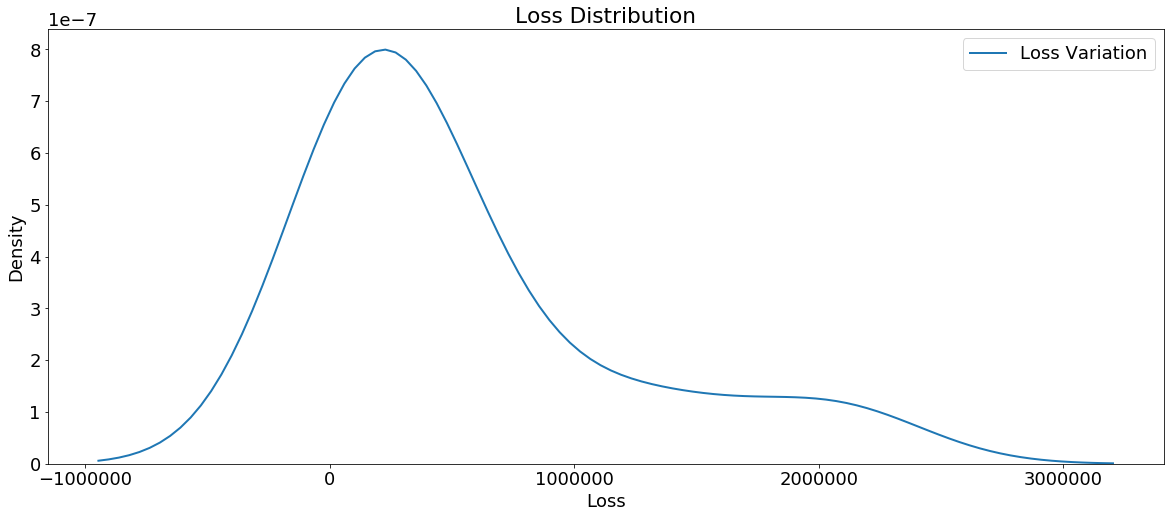

In [13]:
os.chdir('./plots')
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['loss'], label = 'Loss Variation', linewidth = 2)
plt.legend()
plt.xlabel('Loss'); plt.ylabel('Density'); plt.title('Loss Distribution');
plt.savefig(file_suffix+'_loss.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


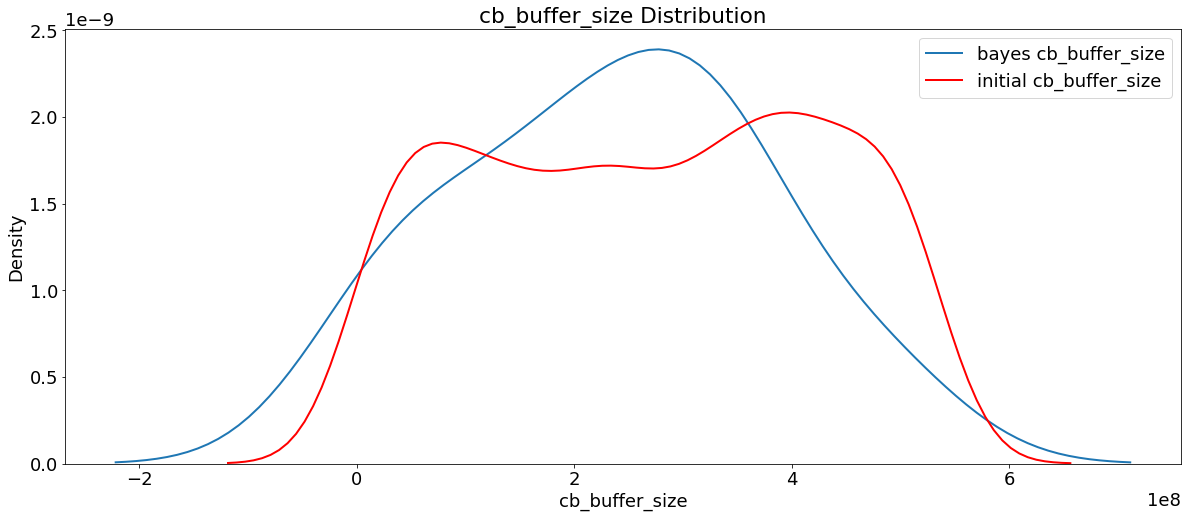

In [14]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18


sns.kdeplot(bayes_params['cb_buffer_size'], label = 'bayes cb_buffer_size', linewidth = 2)
sns.kdeplot(cb_buffer_size_dist,color="red",linewidth=2, label = 'initial cb_buffer_size')

plt.legend()
plt.xlabel('cb_buffer_size'); plt.ylabel('Density'); plt.title('cb_buffer_size Distribution');
plt.savefig(file_suffix+'_cb_buffer_size.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


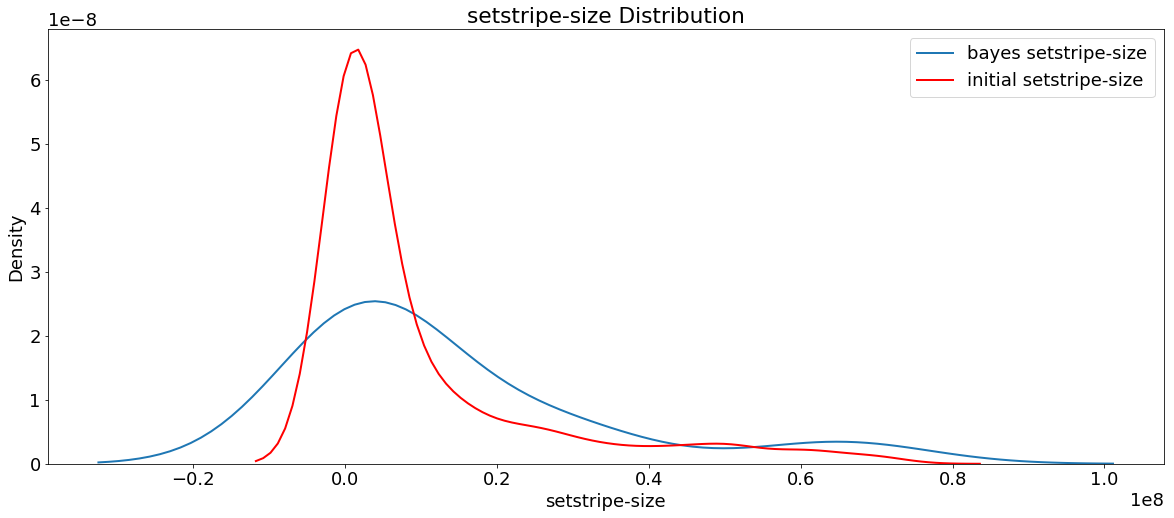

In [15]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-size'], label = 'bayes setstripe-size', linewidth = 2)
sns.kdeplot(setstripe_size_dist,color="red",linewidth=2, label = 'initial setstripe-size')

plt.legend()
plt.xlabel('setstripe-size'); plt.ylabel('Density'); plt.title('setstripe-size Distribution');
plt.savefig(file_suffix+'_setstripe-size.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


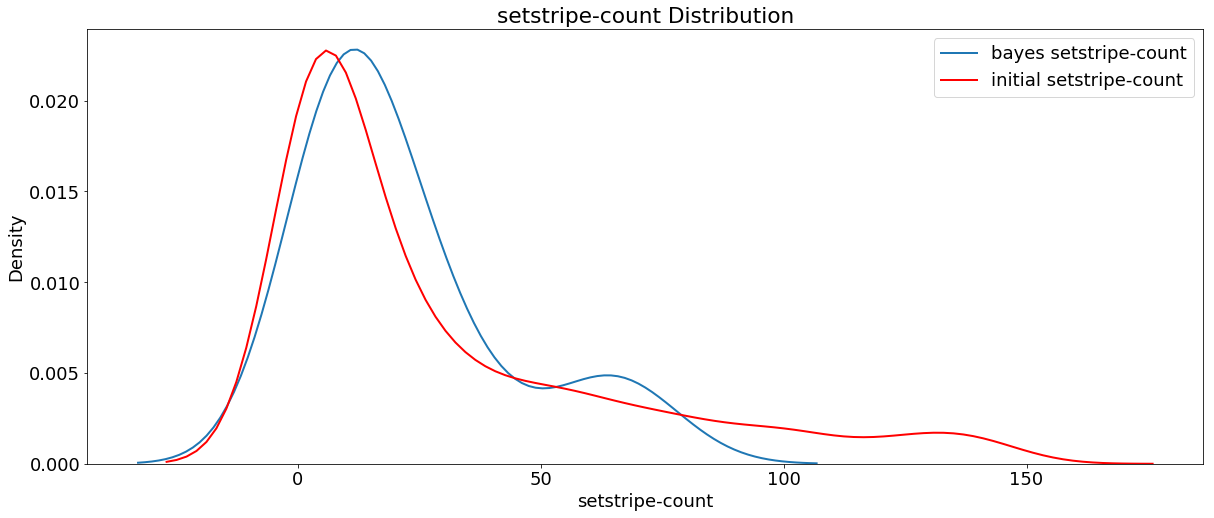

In [16]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-count'], label = 'bayes setstripe-count', linewidth = 2)
sns.kdeplot(setstripe_count_dist,color="red",linewidth=2, label = 'initial setstripe-count')

plt.legend()
plt.xlabel('setstripe-count'); plt.ylabel('Density'); plt.title('setstripe-count Distribution');
plt.savefig(file_suffix+'_setstripe-count.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


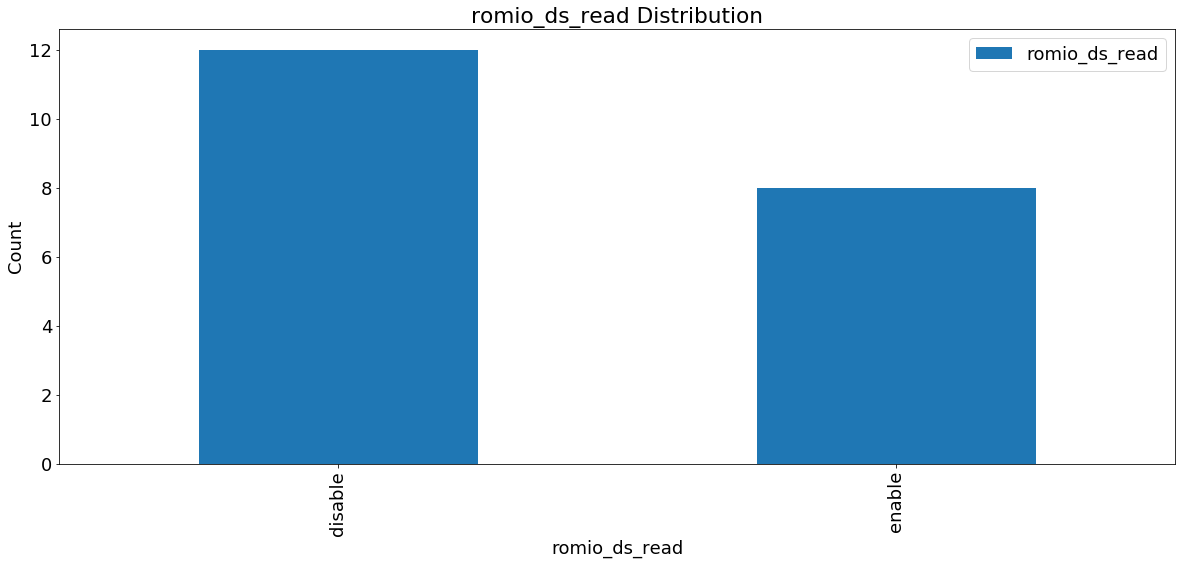

In [17]:
plt.figure(figsize = (20, 8))
from scipy.stats import itemfreq
plt.rcParams['font.size'] = 18
bayes_params['romio_ds_read'].value_counts().plot.bar()#plt.hist(romio_ds_read_dist,color="red",linewidth=2, label = 'initial romio_ds_read')

plt.legend()
plt.xlabel('romio_ds_read'); plt.ylabel('Count'); plt.title('romio_ds_read Distribution');
plt.savefig(file_suffix+'_romio_ds_read.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


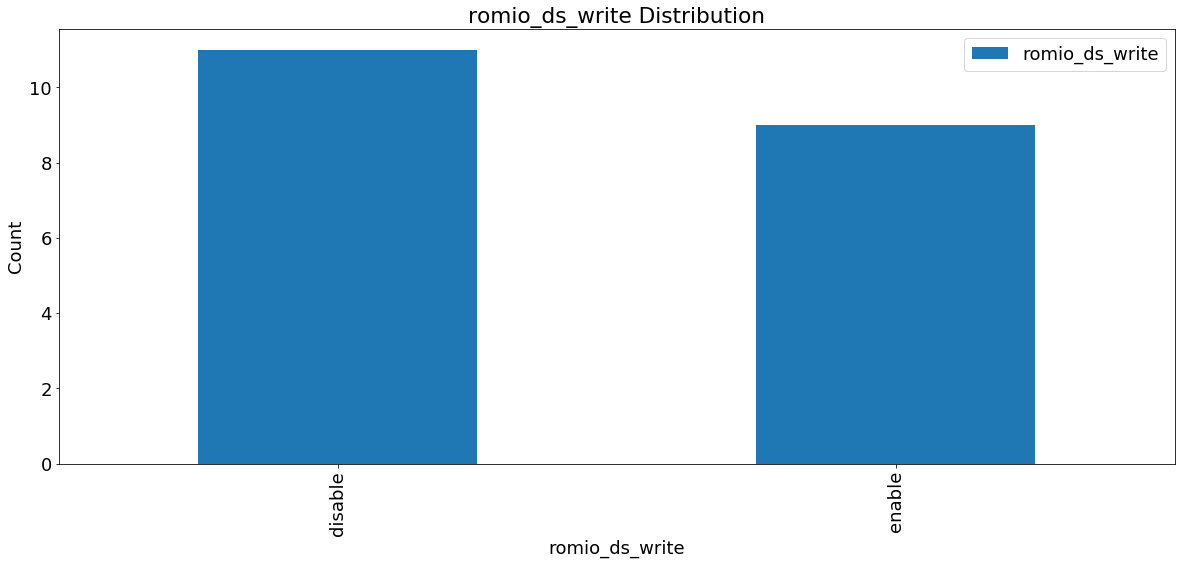

In [18]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

#plt.hist(bayes_params['romio_ds_write'], label = 'bayes romio_ds_write', linewidth = 2)
#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_ds_write')
bayes_params['romio_ds_write'].value_counts().plot.bar()
plt.legend()
plt.xlabel('romio_ds_write'); plt.ylabel('Count'); plt.title('romio_ds_write Distribution');
plt.savefig(file_suffix+'_romio_ds_write.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


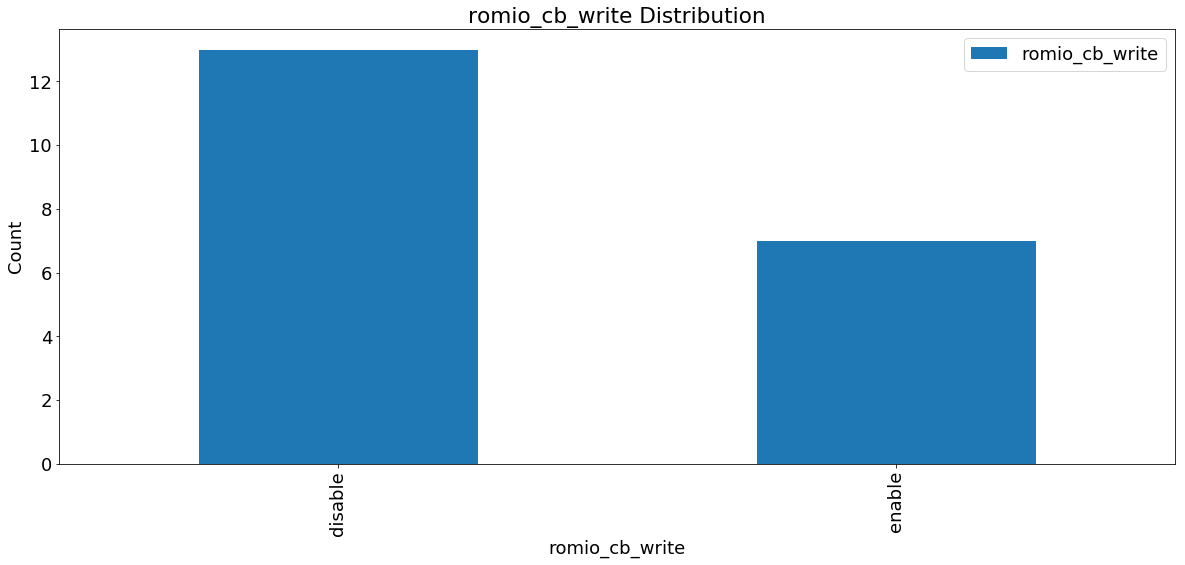

In [19]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

bayes_params['romio_cb_write'].value_counts().plot.bar()#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_cb_write')

plt.legend()
plt.xlabel('romio_cb_write'); plt.ylabel('Count'); plt.title('romio_cb_write Distribution');
plt.savefig(file_suffix+'_romio_cb_write.png')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


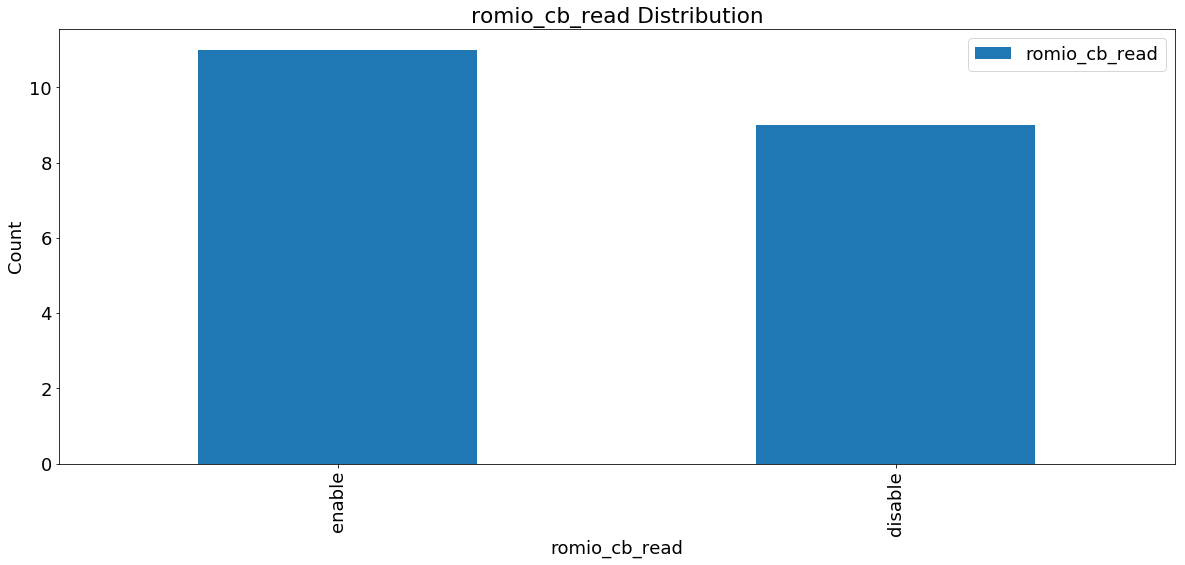

In [20]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

bayes_params['romio_cb_read'].value_counts().plot.bar()#plt.hist(romio_cb_read_dist,color="red",linewidth=2, label = 'initial romio_cb_read')

plt.legend()
plt.xlabel('romio_cb_read'); plt.ylabel('Count'); plt.title('romio_cb_read Distribution');
plt.savefig(file_suffix+'_romio_cb_read.png')

In [21]:
os.chdir('../')